In [1]:
import numpy as np

from os import listdir
from os.path import isfile, join

import dgl
from dgl.nn import RelGraphConv

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from DB.propaganda_db import DB

from dgl.nn import GraphConv, AvgPooling
from dgl.nn.pytorch import Sequential

from dgl.dataloading import GraphDataLoader
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

import pickle

from copy import deepcopy

In [2]:
def filter_name(url):
    if "http" in url:
        basename = url.split("/")[2]
    else:
        basename = url.split(" ")[0]
        pass
    if "www" == basename[:3]:
        return basename[4:]
    return basename

In [3]:
def get_dataset(db_paths, label):
    dataset = []
    for db_path in db_paths:
        db = DB(db_path)
        urls = db.get_url_by_id(1)[0][0]
        n2i = dict()
        cur_edges, cur_nodes = db.get_tree(urls)
        if len(cur_edges) == 0:
            continue
        
        domain_nodes = {}
        node_fvs=torch.zeros((len(cur_nodes), 3))
        node_ctr = 0
        for n in cur_nodes.keys():
            if filter_name(n) not in domain_nodes:
                domain_nodes[filter_name(n)] =[n]
            else:
                domain_nodes[filter_name(n)].append(n)
                
            if n not in n2i:
                n2i[n] = node_ctr
                node_fvs[node_ctr, cur_nodes[n][1]] = 1
                node_ctr += 1
                
        new_nodes = set(cur_nodes.keys())
        new_edges = [((source, target), {'edge_type': edge_type}) for _, source, target, edge_type
                     in cur_edges]
        
        from_list = []
        to_list = []
        edge_types = []
        for _, source, target, edge_type in cur_edges:
            to_list.append(n2i[source])
            from_list.append(n2i[target])
            if edge_type == 'title':
                edge_types.append(0)
            elif edge_type == 'link':
                edge_types.append(1)
            else:
                print("aa", edge_type)
        for domain in domain_nodes:
            nodes = domain_nodes[domain]
            for n1 in nodes:
                for n2 in nodes:
                    if n1 != n2:
                        from_list.append(n2i[n1])
                        to_list.append(n2i[n2])
                        edge_types.append(2)
                        from_list.append(n2i[n2])
                        to_list.append(n2i[n1])
                        edge_types.append(2)

                        
        g = dgl.graph((from_list, to_list))
        g.ndata['h'] = node_fvs
        g.edata['type'] = torch.tensor(edge_types)
        dataset.append((g, torch.tensor([float(label)])))
    return dataset

create_dataset = False
if create_dataset:
    normal_path = "C:\\EuVsDisinfo_dataset\\normal\\databases"
    normal_databases = [normal_path + "\\" + f for f in listdir(normal_path) if
                        isfile(join(normal_path, f)) and f.endswith(".db")]

    propaganda_path = "C:\\EuVsDisinfo_dataset\\propaganda\\databases"
    propaganda_databases = [propaganda_path + "\\" + f for f in listdir(propaganda_path) if
                            isfile(join(propaganda_path, f)) and f.endswith(".db")]
    
    normal_dataset = get_dataset(normal_databases, 0)
    propaganda_dataset = get_dataset(propaganda_databases, 1)
    dataset = [*normal_dataset, *propaganda_dataset]
    with open('knowledge_graph_datset.pickle', 'wb') as f:
        pickle.dump(dataset, f)
else:
    with open('knowledge_graph_datset.pickle', 'rb') as f:
        dataset = pickle.load(f)

In [4]:
class RGCN(nn.Module):
    def __init__(self, hidden_features, dropout):
        super(RGCN, self).__init__()
        self.in_layer = RelGraphConv(3, hidden_features, 3, activation=nn.ReLU())
        self.dropout1 = nn.Dropout(dropout)
        self.out_layer = RelGraphConv(hidden_features, hidden_features, 3, activation=nn.ReLU())
        self.dropout2 = nn.Dropout(dropout)
        self.global_mean_pool = dgl.nn.pytorch.glob.AvgPooling()
        
        self.fc = nn.Linear(hidden_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, in_feat, e_types):
        h = self.in_layer(g, in_feat, e_types)
        h = self.dropout1(h)
        h = self.out_layer(g, h, e_types)
        h = self.dropout2(h)
        h = self.global_mean_pool(g, h)
        h = self.fc(h)
        
        return self.sigmoid(h)


In [5]:
def evaluate(model, dataloader):
    model.eval()
    num_correct = 0
    num_tests = 0
    for batched_graph, labels in dataloader:
        pred = torch.round(model(batched_graph, batched_graph.ndata['h'].float(), batched_graph.edata['type']))
        num_correct += (pred==labels).sum().float().item()
        num_tests += len(labels)
    return num_correct / num_tests

def train(model, device, train_loader, optimizer, epoch, training=True):
    Loss = nn.BCELoss()
    
    if training:
        model.train()
    else:
        model.eval()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data, data.ndata['h'].float(), data.edata['type'])
#         loss = F.nll_loss(output, target)
        
        
        loss = Loss(output, target)
        if not training:
            return loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()
    

In [6]:
dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

In [7]:
splits=KFold(n_splits=5,shuffle=True,random_state=42)
num_epochs=50
from itertools import product
hidden_size = [4,8,12,16, 32]
dropout = [0., 0.2, 0.5, 0.7]
model_params = list(product(hidden_size, dropout))
print(len(model_params))

20


In [8]:
best_test_acc = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
models = [RGCN(*p) for p in model_params]

optimizers = [torch.optim.Adam(model.parameters(), lr=0.1) for model in models]
# schedulers = [lr_scheduler.CosineAnnealingLR(optimizer, num_epochs) for optimizer in optimizers]
schedulers = [None for optimizer in optimizers]
results = []
for i, (model) in enumerate(models):
    foldperf = {}
    print(f"model {i}/{len(models)}")
    print(model_params[i])
    
    for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
        lrs = []


        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)
        train_loader = GraphDataLoader(dataset, batch_size=1000, sampler=train_sampler)
        test_loader = GraphDataLoader(dataset, batch_size=1000, sampler=test_sampler)

        optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
        history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

        for epoch in range(num_epochs):
            train_loss = train(model,device,train_loader,optimizer, epoch, True)
            train_acc = evaluate(model, train_loader)
            test_loss = train(model,device,test_loader,optimizer, epoch, False)
            test_acc = evaluate(model, test_loader)
#             scheduler.step()
#             lrs.append(scheduler.get_last_lr())
            if best_test_acc < test_acc:
                best_test_acc = test_acc
                best_model = deepcopy(model)

            if epoch == num_epochs-1:
                print("\nF{}, Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(fold+1, epoch + 1,
                                                                                                                 num_epochs,
                                                                                                                 train_loss,
                                                                                                                 test_loss,
                                                                                                                 100*train_acc,
                                                                                                                 100*test_acc))

            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
            history['train_acc'].append(train_acc)
            history['test_acc'].append(test_acc)
        foldperf[f'fold{fold+1}'] = history  
    results.append(foldperf)
#     break


model 0/20
(4, 0.0)


C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



F1, Epoch:50/50 AVG Training Loss:0.446 AVG Test Loss:0.569 AVG Training Acc 78.38 % AVG Test Acc 70.21 %

F2, Epoch:50/50 AVG Training Loss:0.412 AVG Test Loss:0.567 AVG Training Acc 81.62 % AVG Test Acc 74.47 %

F3, Epoch:50/50 AVG Training Loss:0.355 AVG Test Loss:0.564 AVG Training Acc 83.87 % AVG Test Acc 73.91 %

F4, Epoch:50/50 AVG Training Loss:0.383 AVG Test Loss:0.680 AVG Training Acc 81.72 % AVG Test Acc 71.74 %

F5, Epoch:50/50 AVG Training Loss:0.421 AVG Test Loss:0.476 AVG Training Acc 82.80 % AVG Test Acc 84.78 %
model 1/20
(4, 0.2)

F1, Epoch:50/50 AVG Training Loss:0.531 AVG Test Loss:0.541 AVG Training Acc 78.92 % AVG Test Acc 78.72 %

F2, Epoch:50/50 AVG Training Loss:0.543 AVG Test Loss:0.613 AVG Training Acc 80.54 % AVG Test Acc 72.34 %

F3, Epoch:50/50 AVG Training Loss:0.532 AVG Test Loss:0.482 AVG Training Acc 82.80 % AVG Test Acc 78.26 %

F4, Epoch:50/50 AVG Training Loss:0.521 AVG Test Loss:0.577 AVG Training Acc 80.11 % AVG Test Acc 69.57 %

F5, Epoch:50/50 


F5, Epoch:50/50 AVG Training Loss:0.607 AVG Test Loss:0.523 AVG Training Acc 69.89 % AVG Test Acc 73.91 %
model 15/20
(16, 0.7)

F1, Epoch:50/50 AVG Training Loss:0.635 AVG Test Loss:0.649 AVG Training Acc 63.78 % AVG Test Acc 70.21 %

F2, Epoch:50/50 AVG Training Loss:0.683 AVG Test Loss:0.677 AVG Training Acc 63.78 % AVG Test Acc 59.57 %

F3, Epoch:50/50 AVG Training Loss:0.620 AVG Test Loss:0.635 AVG Training Acc 70.43 % AVG Test Acc 60.87 %

F4, Epoch:50/50 AVG Training Loss:0.614 AVG Test Loss:0.619 AVG Training Acc 66.67 % AVG Test Acc 65.22 %

F5, Epoch:50/50 AVG Training Loss:4.816 AVG Test Loss:4.862 AVG Training Acc 69.35 % AVG Test Acc 69.57 %
model 16/20
(32, 0.0)

F1, Epoch:50/50 AVG Training Loss:7.745 AVG Test Loss:6.916 AVG Training Acc 69.19 % AVG Test Acc 63.83 %

F2, Epoch:50/50 AVG Training Loss:0.368 AVG Test Loss:0.608 AVG Training Acc 83.24 % AVG Test Acc 72.34 %

F3, Epoch:50/50 AVG Training Loss:0.296 AVG Test Loss:0.487 AVG Training Acc 85.48 % AVG Test Acc 8

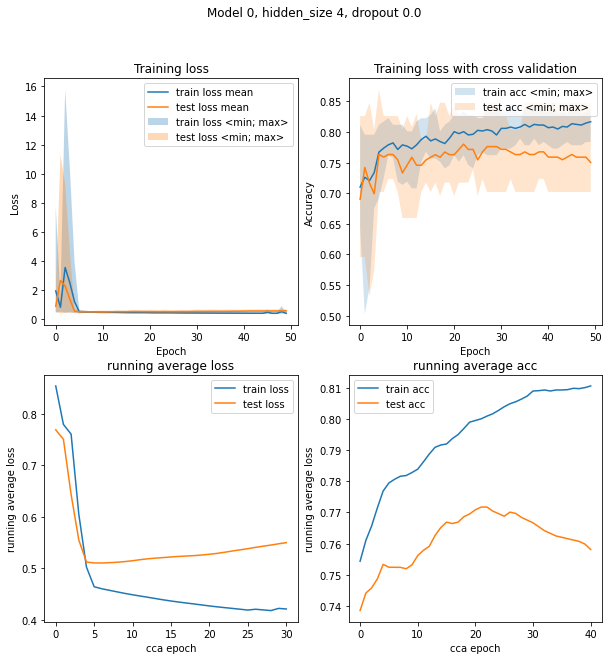

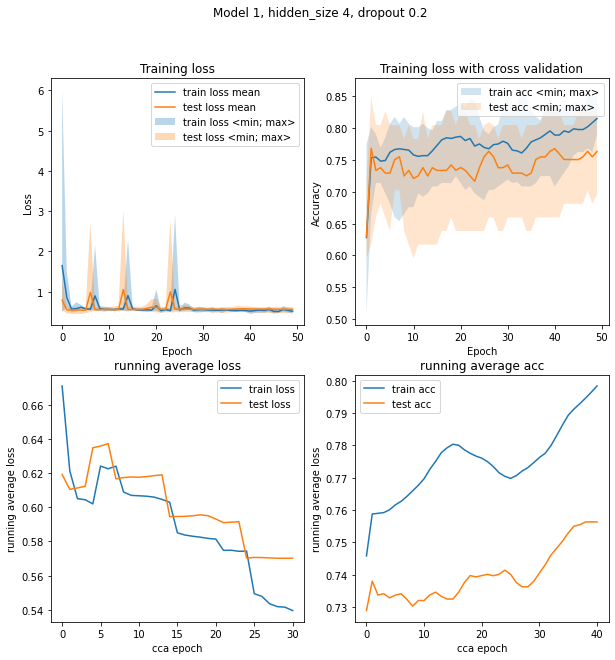

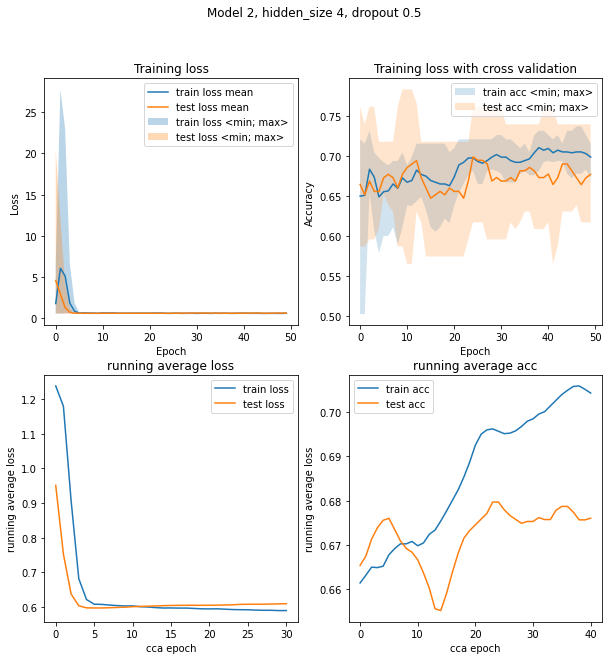

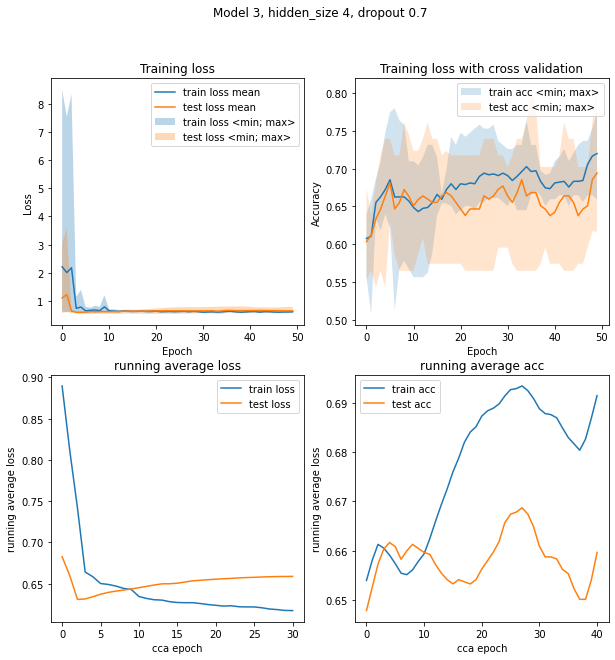

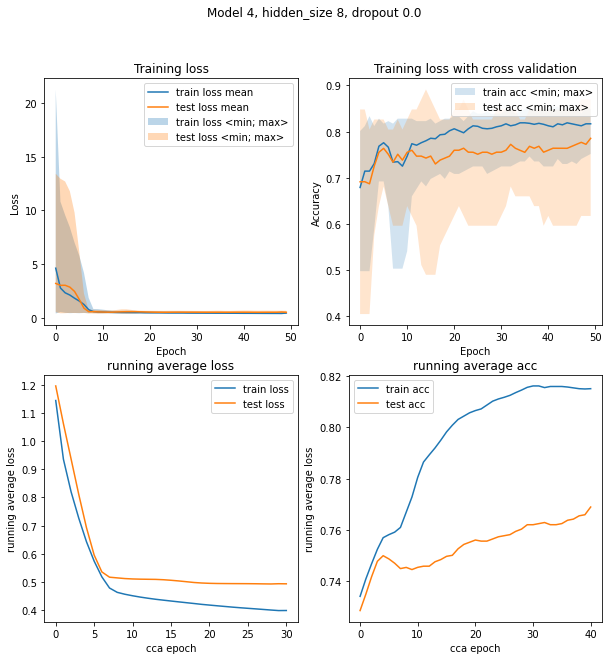

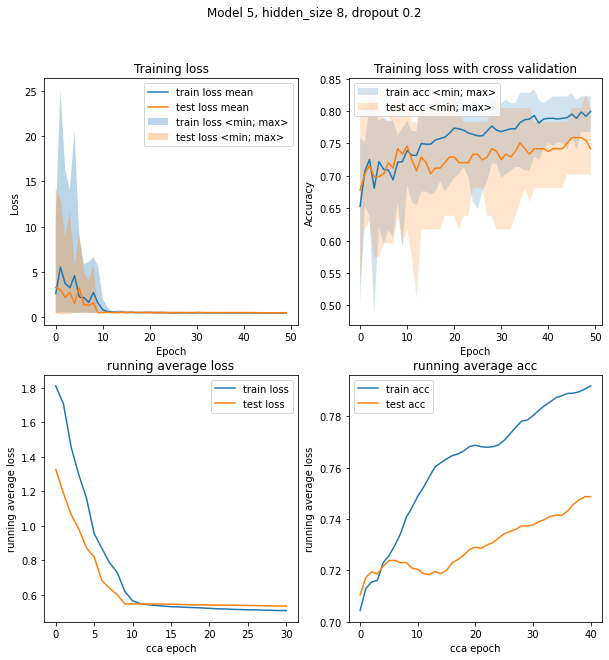

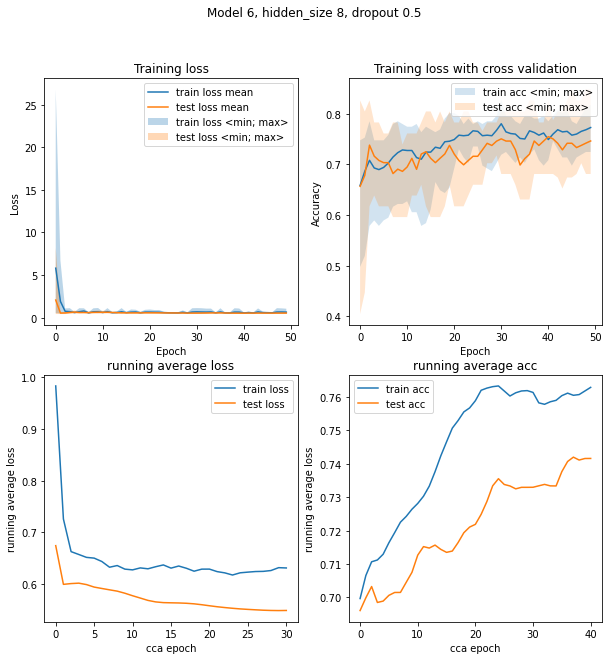

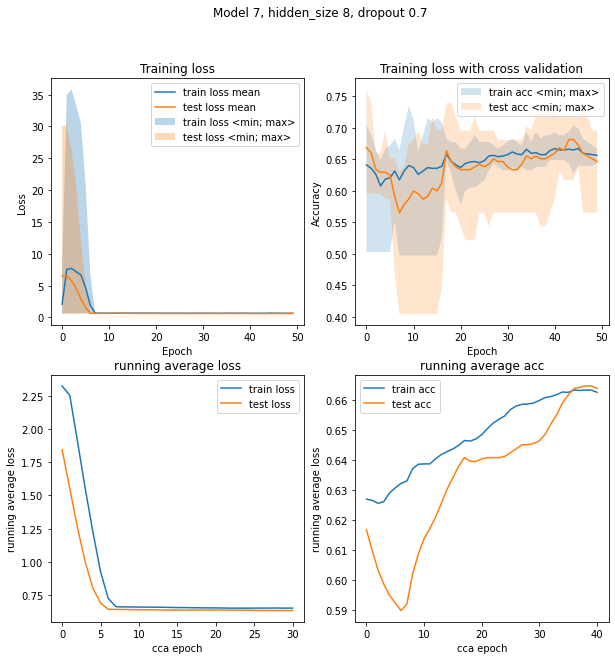

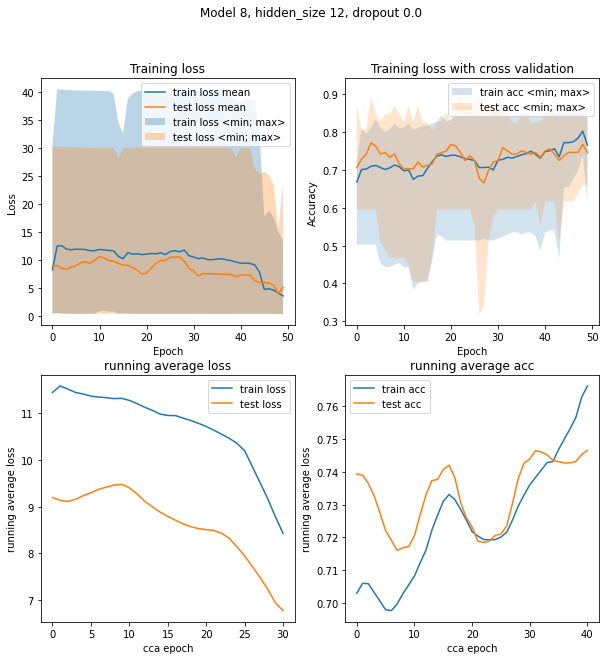

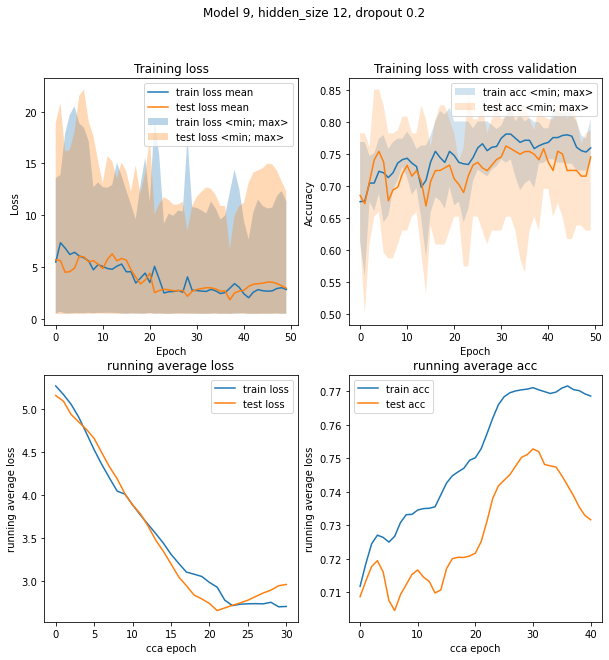

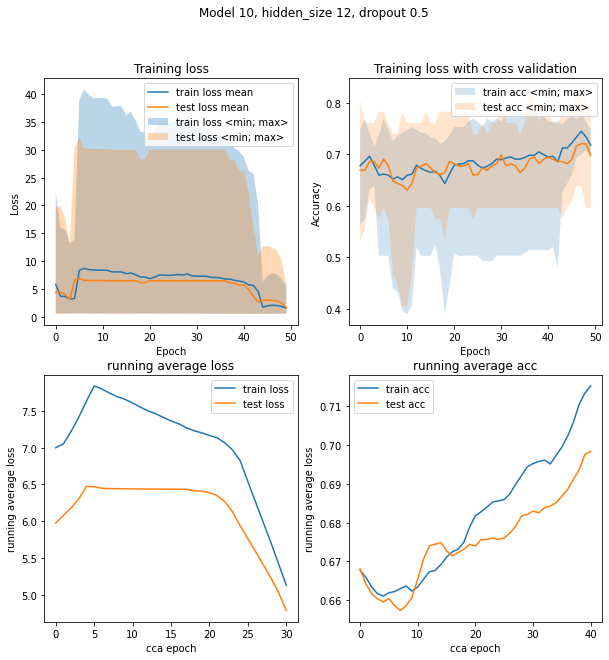

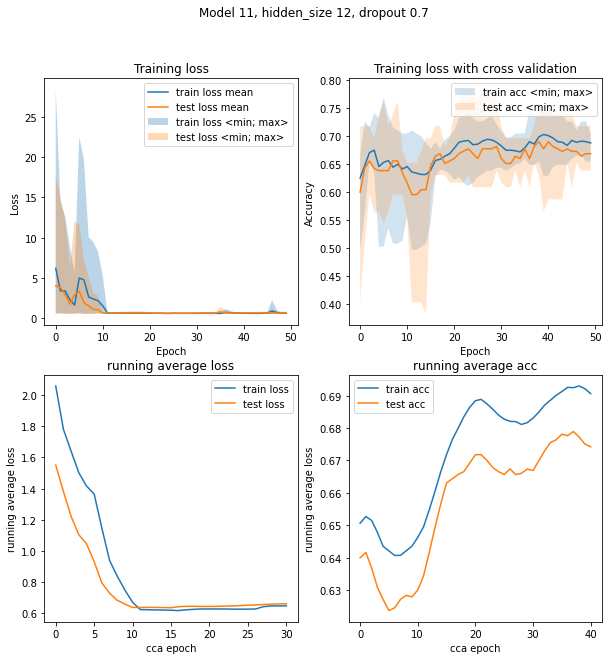

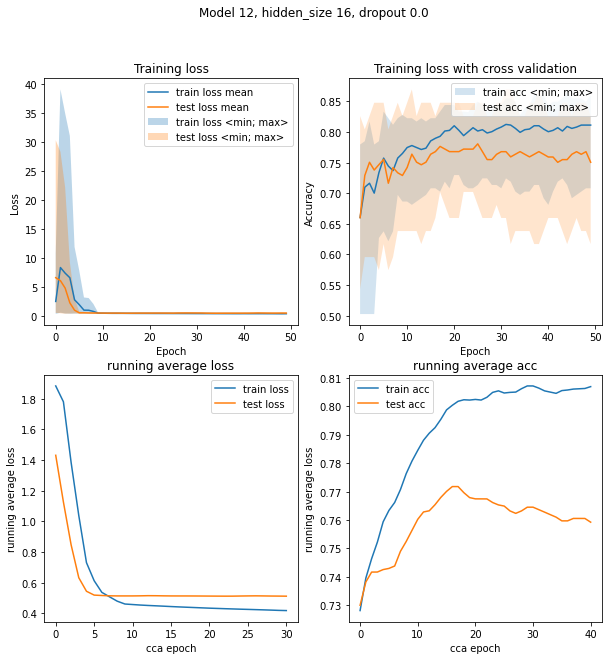

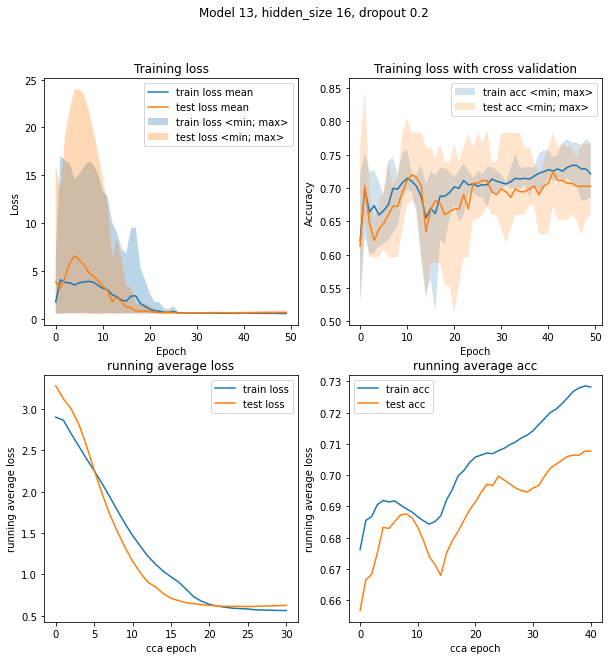

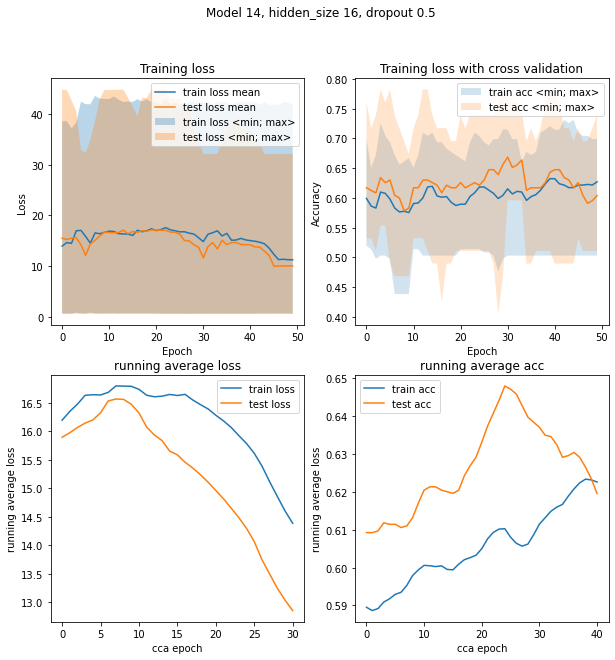

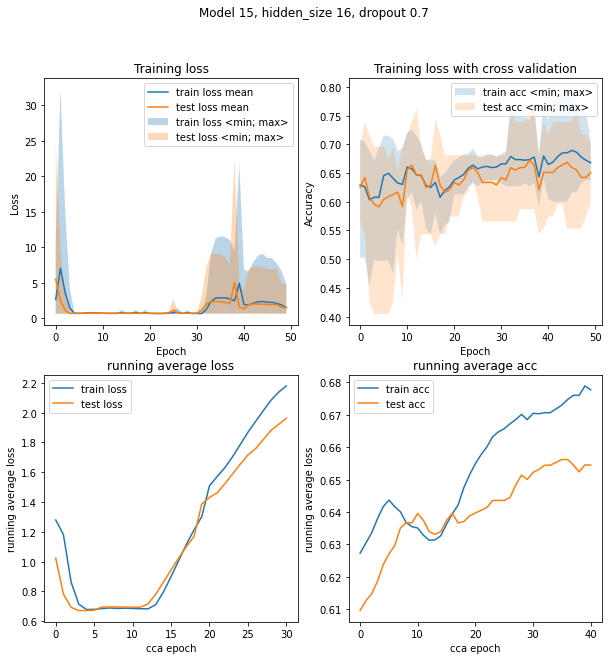

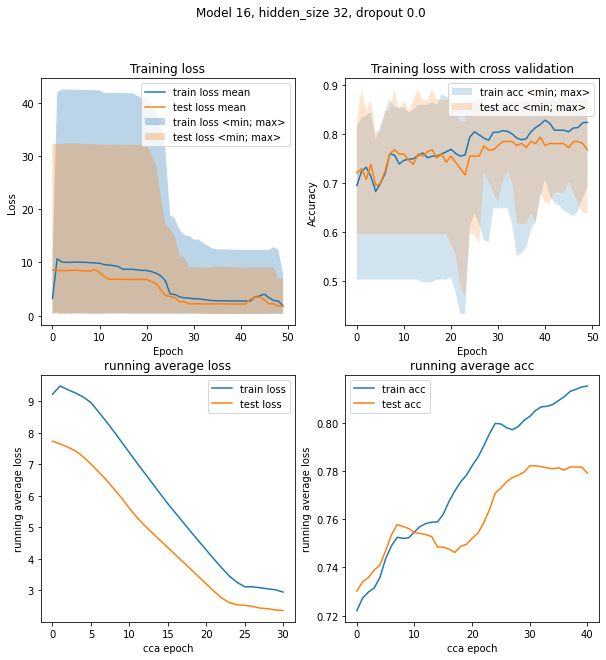

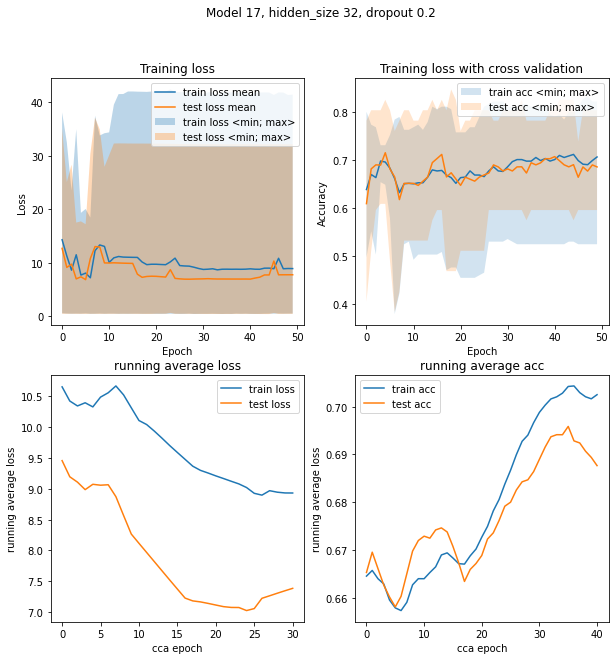

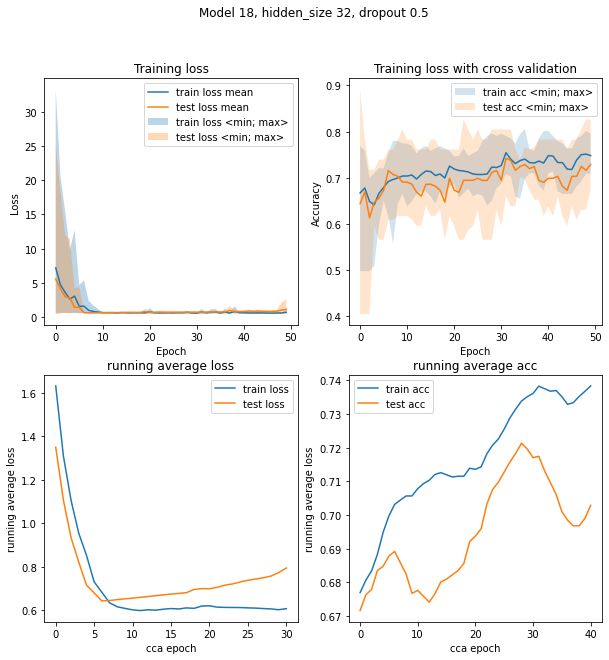

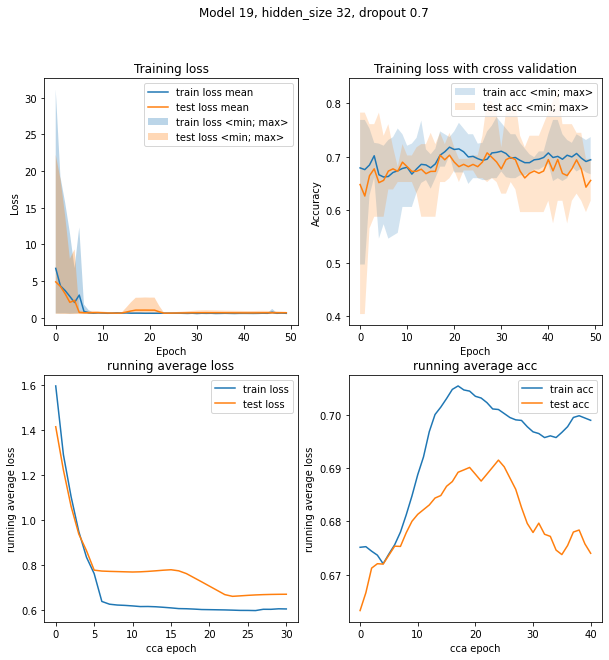

In [9]:
for i, foldperf in enumerate(results):
    train_loss = np.vstack([foldperf[fold]['train_loss'] for fold in foldperf])
    test_loss = np.vstack([foldperf[fold]['test_loss'] for fold in foldperf])
    train_acc = np.vstack([foldperf[fold]['train_acc'] for fold in foldperf])
    test_acc = np.vstack([foldperf[fold]['test_acc'] for fold in foldperf])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle(f'Model {i}, hidden_size {model_params[i][0]}, dropout {model_params[i][1]}')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.title.set_text('Training loss')
    ax1.fill_between(range(num_epochs), train_loss.min(0), train_loss.max(0), alpha=0.3, label="train loss <min; max>")
    ax1.fill_between(range(num_epochs), test_loss.min(0), test_loss.max(0), alpha=0.3, label="test loss <min; max>")

    ax1.plot(range(num_epochs), train_loss.mean(0), label='train loss mean')
    ax1.plot(range(num_epochs), test_loss.mean(0), label='test loss mean')
    ax1.legend()
    
    
    
    ax2.title.set_text("Training loss with cross validation")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.fill_between(range(num_epochs), train_acc.min(0), train_acc.max(0), alpha=0.2, label="train acc <min; max>")
    ax2.fill_between(range(num_epochs), test_acc.min(0), test_acc.max(0), alpha=0.2, label="test acc <min; max>")

    ax2.plot(range(num_epochs), train_acc.mean(0))

    ax2.plot(range(num_epochs), test_acc.mean(0))
    ax2.legend()

    
    
    ax3.title.set_text('running average loss')
    ax3.plot(np.convolve(train_loss.mean(0), np.ones(20)/20, mode='valid'), label='train loss')
    ax3.plot(np.convolve(test_loss.mean(0), np.ones(20)/20, mode='valid'), label='test loss')
    ax3.set_xlabel('cca epoch')
    ax3.set_ylabel('running average loss')

    ax3.legend()
    
    ax4.title.set_text('running average acc')
    ax4.plot(np.convolve(train_acc.mean(0), np.ones(10)/10, mode='valid'), label='train acc')
    ax4.plot(np.convolve(test_acc.mean(0), np.ones(10)/10, mode='valid'), label='test acc')
    ax4.plot(test_acc.median(0), label('test acc median')
    ax4.set_xlabel('cca epoch')
    ax4.set_ylabel('running average loss')
    ax4.legend()
    plt.show()


In [10]:
test_loader = GraphDataLoader(test_dataset)
print('test accuracy: {:.2f}%'.format(100*evaluate(best_model, test_loader)))

test accuracy: 72.88%


In [11]:
print(f'best model val acc {best_test_acc*100}%')

best model val acc 91.30434782608695%


In [12]:
train_loss = np.vstack([foldperf[fold]['train_loss'] for fold in foldperf])
test_loss = np.vstack([foldperf[fold]['test_loss'] for fold in foldperf])
train_acc = np.vstack([foldperf[fold]['train_acc'] for fold in foldperf])
test_acc = np.vstack([foldperf[fold]['test_acc'] for fold in foldperf])


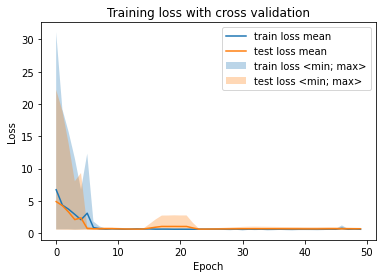

In [13]:
plt.figure()
plt.title("Training loss with cross validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.fill_between(range(num_epochs), train_loss.min(0), train_loss.max(0), alpha=0.3, label="train loss <min; max>")
plt.fill_between(range(num_epochs), test_loss.min(0), test_loss.max(0), alpha=0.3, label="test loss <min; max>")
# plt.fill_between(range(num_epochs), train_loss.mean(0)-train_loss.std(0), train_loss.mean(0)+train_loss.std(0), y1, alpha=0.3, label="std")
# plt.plot(range(num_epochs), train_loss.mean(0)-train_loss.std(0), 'y-.', alpha=0.6, label="mean loss +- std") #, train_loss.mean(0)+train_loss.std(0), y1, alpha=0.3, label="std")
# plt.plot(range(num_epochs), train_loss.mean(0)+train_loss.std(0), 'y-.', alpha=0.6) #, train_loss.mean(0)+train_loss.std(0), y1, alpha=0.3, label="std")

plt.plot(range(num_epochs), train_loss.mean(0), label='train loss mean')
plt.plot(range(num_epochs), test_loss.mean(0), label='test loss mean')

plt.legend()
# plt.savefig("training_loss.png")
plt.show()

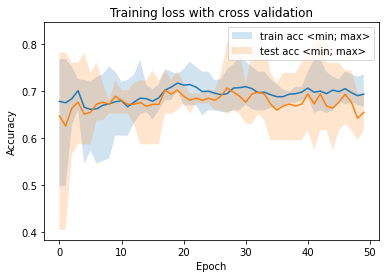

In [14]:
plt.figure()
plt.title("Training loss with cross validation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.fill_between(range(num_epochs), train_acc.min(0), train_acc.max(0), alpha=0.2, label="train acc <min; max>")
plt.fill_between(range(num_epochs), test_acc.min(0), test_acc.max(0), alpha=0.2, label="test acc <min; max>")

plt.plot(range(num_epochs), train_acc.mean(0))

plt.plot(range(num_epochs), test_acc.mean(0))
plt.legend()
plt.show()

In [15]:
test_loader = GraphDataLoader(test_dataset)
print('test accuracy: {:.2f}%'.format(100*evaluate(best_model, test_loader)))

test accuracy: 72.88%


In [16]:
print(model)

RGCN(
  (in_layer): RelGraphConv(
    (linear_r): TypedLinear(in_size=3, out_size=32, num_types=3)
    (activation): ReLU()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (dropout1): Dropout(p=0.7, inplace=False)
  (out_layer): RelGraphConv(
    (linear_r): TypedLinear(in_size=32, out_size=32, num_types=3)
    (activation): ReLU()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (dropout2): Dropout(p=0.7, inplace=False)
  (global_mean_pool): AvgPooling()
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [17]:
best_test_acc

0.9130434782608695

In [18]:
train_acc.max()

0.7741935483870968

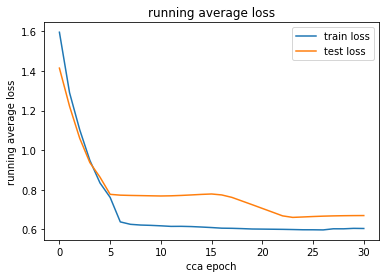

In [19]:
plt.figure()
plt.title('running average loss')
plt.plot(np.convolve(train_loss.mean(0), np.ones(20)/20, mode='valid'), label='train loss')

plt.plot(np.convolve(test_loss.mean(0), np.ones(20)/20, mode='valid'), label='test loss')
plt.xlabel('cca epoch')
plt.ylabel('running average loss')
plt.legend()
plt.show()

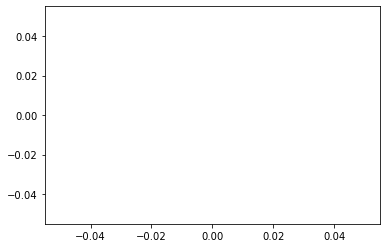

In [20]:
plt.figure()
plt.plot(lrs)
plt.show()

In [21]:
model

RGCN(
  (in_layer): RelGraphConv(
    (linear_r): TypedLinear(in_size=3, out_size=32, num_types=3)
    (activation): ReLU()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (dropout1): Dropout(p=0.7, inplace=False)
  (out_layer): RelGraphConv(
    (linear_r): TypedLinear(in_size=32, out_size=32, num_types=3)
    (activation): ReLU()
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (dropout2): Dropout(p=0.7, inplace=False)
  (global_mean_pool): AvgPooling()
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)